In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
def train_using_Regression(p,train,test,col):
  # splitting the values in x_train and y_train for training a regression model
  x_train = train.iloc[:,1:].values.reshape(-1,p)
  y_train = train.iloc[:,0].values.reshape(-1,1)
  #print("Train data is:\n",train)
  #print("Test data is:\n",test)
  # using the linear regression model from sklearn to optimise the value of parameter
  model = LinearRegression()
  model.fit(x_train,y_train)
  # getting the value of the thera and intercept 
  theta  = model.coef_.T
  intercept = model.intercept_
  # stroing the values of predicted values
  train['Predicted_Values'] = x_train.dot(theta) + intercept
  # checking the values of prediction and calculating the error
  x_test = test.iloc[:,1:].values.reshape(-1,p)
  test['Predicted_Values'] = x_test.dot(theta) + intercept
  # calculating the value of error using mean squared error
  RMSE = np.sqrt(mean_squared_error(test[col], test['Predicted_Values']))
  return [train,test,theta,intercept,RMSE]

def Auto_regressive(p,df):
  # creating the copy of the given database
  df_t = df.copy()
  #Generating the lagged p terms
  for i in range(1,p+1):
    df_t['Shifted_values_%d' % i ] = df_t['Value'].shift(i)
  # dropping the null values
  df_t = df_t.dropna()
  # splitting the data for training and testing
  size = (int)(0.7 * df_t.shape[0]) 
  train = pd.DataFrame(df_t[0:size])
  test = pd.DataFrame(df_t[size:])
  #print("Dividing the data set into: ",size,df_t.shape[0]-size)
  #print("Train dataset is:\n",train)
  #print("Test dataset is:\n",test)
  [train,test,theta,intercept,RMSE] = train_using_Regression(p,train,test,"Value")
  print("The RMSE value is: {a:.2f} For value of p = {b}".format(a = RMSE,b = p))
  return [train,test,theta,intercept,RMSE]
    
def Moving_average(q,res):
  # shifting the values to calculate the moving average
  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['errors'].shift(i)
  # dropping the null values
  res = res.dropna()
  # splitting the data into train and test
  size = (int)(0.7 * res.shape[0])
  train = pd.DataFrame(res[0:size])
  test = pd.DataFrame(res[size:res.shape[0]])
  # splititng the values into x_train and y_train
  x_train = train.iloc[:,1:].values.reshape(-1,q)
  y_train = train.iloc[:,0].values.reshape(-1,1)
  #print("Dividing the data set into: ",size,df_t.shape[0]-size)
  #print("Train dataset is:\n",train)
  #print("Test dataset is:\n",test)
  [train,test,theta,intercept,RMSE] = train_using_Regression(q,train,test,"errors")
  print("The RMSE value is: {a:.2f} For value of q = {b}".format(a = RMSE,b = q))
  return [train,test,theta,intercept,RMSE]

def addfuller_test(time_series):
    r = adfuller(time_series)
    #print('Augmented Dickey-Fuller Test:')
    ls= ['AIC']
    for v,l in zip(r,ls):
        print(l+' : '+str(v) )
        AIC = v
    if r[1] <= 0.05:
        #print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
        return True,AIC
    else:
        #print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")
        return False,AIC
# defining the function to check stationarity
def stationarity(df,iterations):
  test = df.copy()
  d = []
  a = []
  for i in range(1,iterations):
    df_testing = pd.DataFrame((test['Value'] - test['Value'].shift(i)).dropna())
    df_testing.columns = ['Value']
    #print(df_testing)
    res,aic = addfuller_test(df_testing.Value)
    if res == True:
      d.append(i)
      a.append(aic)
  if len(a) == 0:
    return 1
  else:
    i = a.index(min(a))
    return d[i]

         Date  Value
150  01-07-04   5773
151  01-08-04   5948
152  01-09-04   5546
153  01-10-04   5785
154  01-11-04   5481
..        ...    ...
335  01-12-19   8669
336  01-01-20   8971
337  01-02-20  10567
338  01-03-20   9314
339  01-04-20   6395

[190 rows x 2 columns]


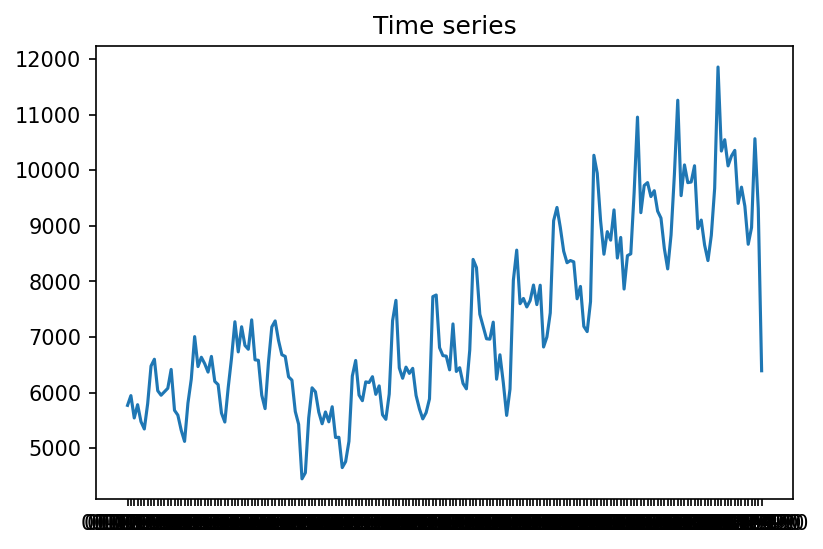

In [22]:
dfd = pd.read_csv('Data.csv')
dfd.columns=['Date','Value']
s = 150
df = dfd.iloc[s:,:]
print(df)
fig = plt.figure(dpi = 150)
plt.title("Time series")
plt.plot(df.iloc[:,0],df.iloc[:,1])

In [24]:
diff = stationarity(df,12)
print("The Value of Differencing is: ",diff)
SDF = (df['Value']-df['Value'].shift(diff)).dropna()

AIC : -2.6481197398382483
AIC : -2.605982987912038
AIC : -2.8161925970008435
AIC : -2.687515676026043
AIC : -2.9329041167386234
AIC : -2.8328793020705594
AIC : -2.9680491980277295
AIC : -3.175800299898208
AIC : -3.7891046070837127
AIC : -3.1457602999685292
AIC : -2.3179588357961434
The Value of Differencing is:  9


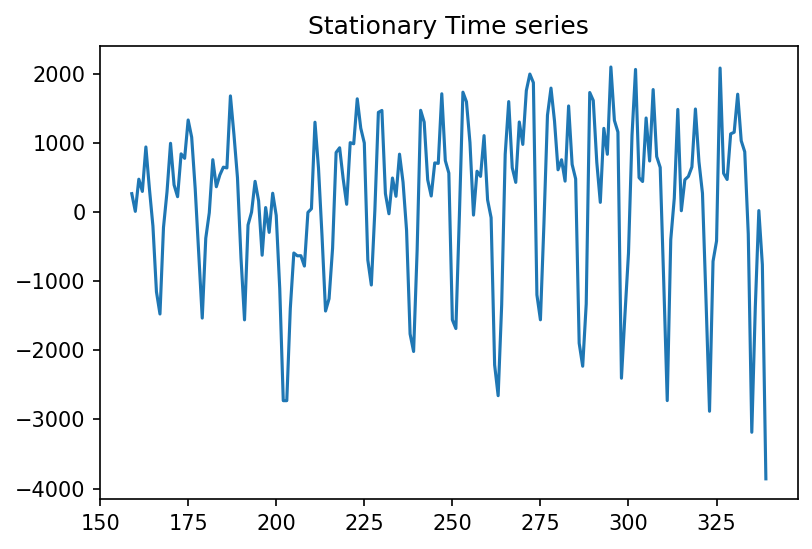

In [25]:
fig = plt.figure(dpi = 150)
plt.title("Stationary Time series")
SDF.plot()

In [26]:
Max_RMSE=100000000000
p = -1
for i in range(1,100):
  [df_train,df_test,theta,intercept,RMSE] = Auto_regressive(i,pd.DataFrame(SDF))
  if(RMSE<Max_RMSE):
    Max_RMSE = RMSE
    p = i
print("The best p value is:",p)

The RMSE value is: 1250.39 For value of p = 1
The RMSE value is: 1254.15 For value of p = 2
The RMSE value is: 1234.95 For value of p = 3
The RMSE value is: 1201.71 For value of p = 4
The RMSE value is: 1203.89 For value of p = 5
The RMSE value is: 1175.51 For value of p = 6
The RMSE value is: 1182.42 For value of p = 7
The RMSE value is: 1141.76 For value of p = 8
The RMSE value is: 1124.09 For value of p = 9
The RMSE value is: 877.25 For value of p = 10
The RMSE value is: 858.75 For value of p = 11
The RMSE value is: 839.47 For value of p = 12
The RMSE value is: 842.78 For value of p = 13
The RMSE value is: 795.10 For value of p = 14
The RMSE value is: 793.68 For value of p = 15
The RMSE value is: 828.69 For value of p = 16
The RMSE value is: 785.79 For value of p = 17
The RMSE value is: 761.36 For value of p = 18
The RMSE value is: 748.16 For value of p = 19
The RMSE value is: 745.17 For value of p = 20
The RMSE value is: 763.59 For value of p = 21
The RMSE value is: 743.49 For valu

In [28]:
print("For Best Auto Regressive model:\n")
[train,test,theta,intercept,RMSE] = Auto_regressive(p,pd.DataFrame(SDF))

For Best Auto Regressive model:

The RMSE value is: 743.49 For value of p = 22


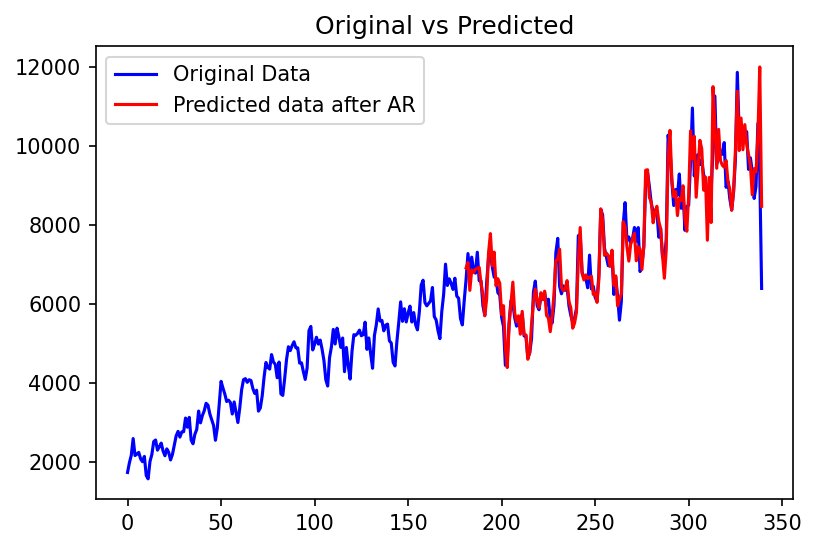

In [33]:
# combining the train and test after the auto regressive part
combined = pd.concat([train,test])
#print(combined)
# plotting the result
fig = plt.figure(dpi = 150)
plt.title("Original vs Predicted")
plt.plot(dfd['Value'],color = 'b')
plt.plot(combined['Predicted_Values']+df['Value'].shift(diff) ,color='r')
plt.legend(['Original Data','Predicted data after AR'])
plt.show()

In [34]:
# creating a dataframe for calculating the moving average on errors in this case the errors are taken as diff between original and predicted  
result = pd.DataFrame()
result['errors'] = combined.Value - combined.Predicted_Values
print(result)

          errors
181  -290.898045
182   225.903959
183   387.876438
184   323.358144
185    53.034205
..           ...
335  -750.071536
336  -367.392034
337   320.831781
338 -2677.360899
339 -2075.618605

[159 rows x 1 columns]


In [35]:
# performing moving average part
Max_RMSE=100000000000
q = -1
for i in range(1,13):
  [etrain,etest,theta,intercept,RMSE] = Moving_average(i,pd.DataFrame(result.errors))
  if(RMSE<Max_RMSE):
    Max_RMSE = RMSE
    q = i
print("The best value of q is: "+str(q))

The RMSE value is: 742.65 For value of q = 1
The RMSE value is: 743.62 For value of q = 2
The RMSE value is: 749.50 For value of q = 3
The RMSE value is: 749.77 For value of q = 4
The RMSE value is: 749.97 For value of q = 5
The RMSE value is: 759.31 For value of q = 6
The RMSE value is: 759.76 For value of q = 7
The RMSE value is: 761.92 For value of q = 8
The RMSE value is: 765.57 For value of q = 9
The RMSE value is: 775.75 For value of q = 10
The RMSE value is: 770.69 For value of q = 11
The RMSE value is: 767.71 For value of q = 12
The best value of q is: 1


In [36]:
print("For optimization of q:")
[etrain,etest,theta,intercept,RMSE] = Moving_average(q,pd.DataFrame(result.errors))
#print(theta)
#print(intercept)

For optimization of q:
The RMSE value is: 742.65 For value of q = 1


In [37]:
result_combined = pd.concat([etrain,etest])
#result_combined.index = result_combined.index 
print(result_combined)

          errors  Shifted_values_1  Predicted_Values
182   225.903959       -290.898045          6.579168
183   387.876438        225.903959         -0.400301
184   323.358144        387.876438         -2.587757
185    53.034205        323.358144         -1.716430
186  -101.075843         53.034205          1.934324
..           ...               ...               ...
335  -750.071536        593.098817         -5.359308
336  -367.392034       -750.071536         12.780357
337   320.831781       -367.392034          7.612228
338 -2677.360899        320.831781         -1.682312
339 -2075.618605      -2677.360899         38.808614

[158 rows x 3 columns]


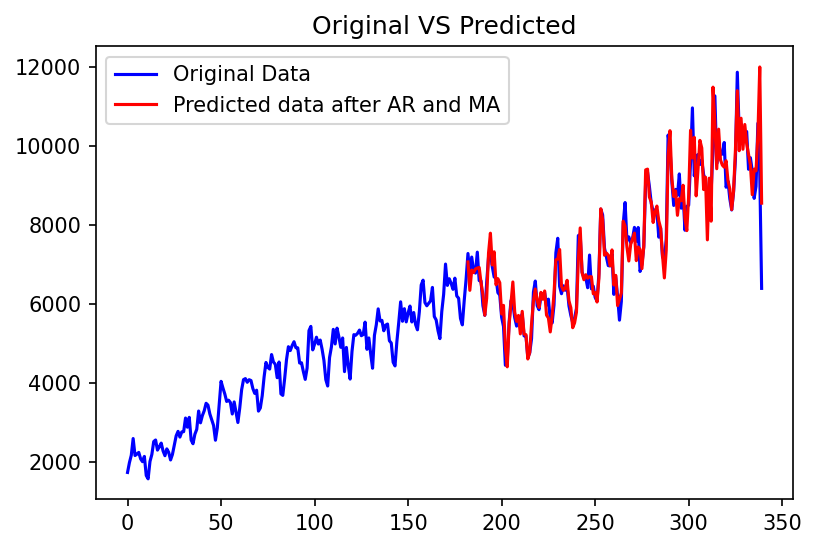

In [39]:
combined.Predicted_Values += result_combined.Predicted_Values
# plotting the fincal result
fig = plt.figure(dpi = 150)
plt.title("Original VS Predicted")
plt.plot(dfd['Value'] ,color = 'b')
# addding the difference to get the original data values
plt.plot(combined['Predicted_Values']+df['Value'].shift(diff), color = 'r')
plt.legend(['Original Data','Predicted data after AR and MA'])
plt.show()

# Using Inbulit models

## Using ARIMA model

In [41]:
# using the same differencing as above and order = (1,0,2)
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
v = (df.Value-df.Value.shift(diff))
df_a = pd.DataFrame({"Date":df.Date,"Value":v})
df_a = df_a.dropna()
#print(df_a)
model=ARIMA(df_a.Value,order=(1,0,2))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Value   No. Observations:                  181
Model:                     ARMA(1, 2)   Log Likelihood               -1472.081
Method:                       css-mle   S.D. of innovations            816.163
Date:                Fri, 25 Mar 2022   AIC                           2954.162
Time:                        13:10:30   BIC                           2970.155
Sample:                             0   HQIC                          2960.646
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         132.0415    167.834      0.787      0.432    -196.908     460.991
ar.L1.Value    -0.0088      0.084     -0.104      0.917      -0.174       0.156
ma.L1.Value     0.9125      0.041     22.484      0.000       0.833       0.992
ma.L2.Value     0.8927      0.082     10.900      0.000       0.732       1.053
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -114.0739           +0.0000j          114.0739            0.5000
MA.1           -0.5111           -0.9268j            1.0584           -0.3302
MA.2           -0.5111           +0.9268j            1.0584            0.3302
-----------------------------------------------------------------------------
"""

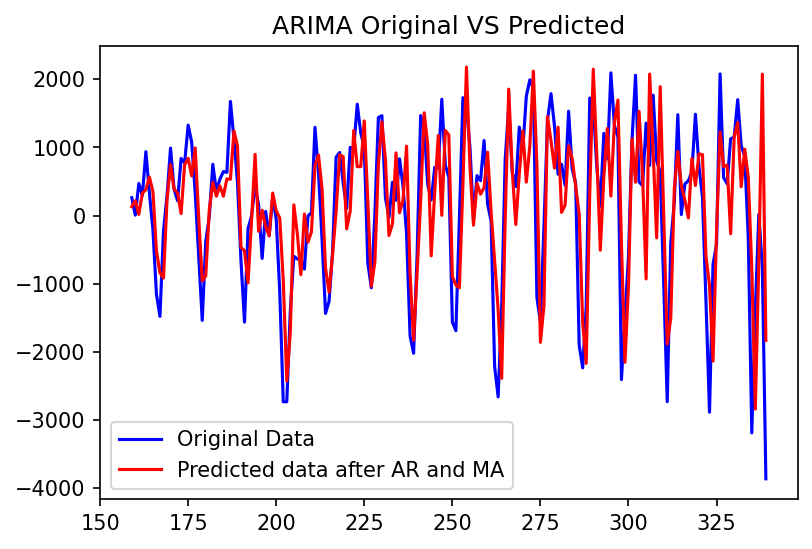

In [46]:
df_a['forcast']=model_fit.predict()
df_a = df_a.dropna()
#print(df_a)
fig = plt.figure(dpi = 150)
plt.title("ARIMA Original VS Predicted")
plt.plot(df_a['Value'] ,color = 'b')
# addding the difference to get the original data values
plt.plot(df_a['forcast'], color = 'r')
plt.legend(['Original Data','Predicted data after AR and MA'])
plt.show()

## Using Seasonal ARIMA model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


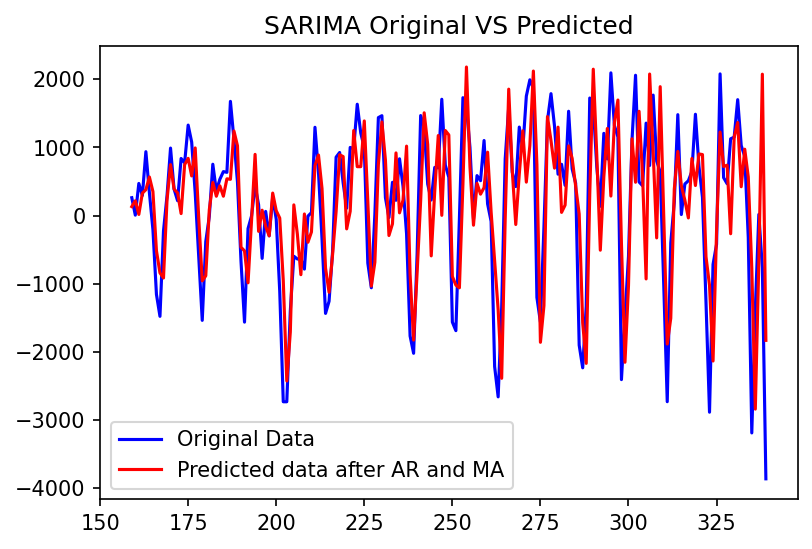

In [52]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_a['Value'],order=(1,1,2),seasonal_order=(1,1,1,12))
results=model.fit()
df_a['forecast']=results.predict()
fig = plt.figure(dpi = 150)
plt.title("SARIMA Original VS Predicted")
plt.plot(df_a['Value'] ,color = 'b')
# addding the difference to get the original data values
plt.plot(df_a['forcast'], color = 'r')
plt.legend(['Original Data','Predicted data after AR and MA'])
plt.show()